In [1]:
import os
import sys
from glob import glob
import numpy as np
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from __future__ import unicode_literals
from IPython.core.display import display, HTML
from pprint import pprint 
import traceback

import radical.utils     as ru
import warnings
import itertools
import matplotlib

warnings.filterwarnings('ignore')
pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)
matplotlib.use("Agg")

In [2]:
# Global configurations
# ---------------------

# Expand the notebook to the width of the browser
display(HTML("<style>.container { width:100% !important; }</style>"))

# Matplotlib style
plt.style.use('seaborn-colorblind')

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = False
mpl.rcParams['text.latex.unicode'] = False
mpl.rcParams['font.family'] = 'Average'
# mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Font sizes
SIZE = 24
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-2)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 1
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['lines.linewidth'] = 2


# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Restore part of matplotlib 1.5 behavior
mpl.rcParams['patch.force_edgecolor'] = True
mpl.rcParams['errorbar.capsize'] = 3

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup(num_x, num_y, (size_x, size_y), (space_x, space_y)=(0.25,0.25)):
    fig, axes = plt.subplots(num_x, num_y, figsize=(size_x, size_y), gridspec_kw={'wspace':space_x, 'hspace':space_y}, sharex=False, sharey=False)
    if num_x == 1 and num_y == 1:
        axes = [[axes]]
#         for ax1 in axes:
#             for ax2 in ax1:
#                 ax2.get_xaxis().tick_bottom()  
#                 ax2.get_yaxis().tick_left()
    elif (num_x == 1 and num_y>1) or (num_x>1 and num_y == 1):
        axes = [axes]
#         for ax1 in axes:
#             for ax2 in ax1:
#                 ax2.get_xaxis().tick_bottom()  
#                 ax2.get_yaxis().tick_left()
    return fig, axes

In [66]:
loc = '../../../data/validation/case_1'
fontsize=18

In [67]:
def parse_uids(uid):
    new_uid = int(uid.split('.')[-1])
    return new_uid

In [68]:
df_dict = dict()
for x in glob('%s/profile.*'%loc):
    json_data = ru.read_json(x)

keys = sorted(json_data.keys())
trials=30
cur_trial = 1
exp = 0
hets = list()

for key in keys:
    if exp==0:
        het = 0
    else:
        het = pow(2,exp)
    
    if het not in hets:
        hets.append(het)
        df_dict[het] = dict()
        
    prof = json_data[key]
    df = pd.DataFrame.from_dict(prof)
    df['core'] = df['core'].apply(parse_uids)
    df['task'] = df['task'].apply(parse_uids)
    df['perf'] = df['ops']/df['exec_time']
    
    df_dict[het][cur_trial] = df
    cur_trial +=1
    if cur_trial > trials:
        cur_trial = 1
        exp+=1
    
print len(df_dict), len(df_dict[0])
print hets

4 30
[0, 2, 4, 8]


In [69]:
def plotter(df):
    
    fig, axes = fig_setup(2,2,(24,20), (0.35,0.35))
    df_manual = None
#     fig, axes = fig_setup(1,1,(12,8))
    
    ax = df.plot(ax=axes[0][0], kind='hist', y=['ops'], title='Histogram of task operations')
    ax.set_xlabel('Task ops')
    ax.set_ylabel('No. of tasks')

    vals = dict()
    for core in df['core'].tolist()[:1]:
        vals[core] = df[df['core'] == core]['perf'].tolist()
    vals_df = pd.DataFrame.from_dict(vals)
    ax = vals_df.plot(ax=axes[0][1], title='Variation of core performance over time', legend=False)
    ax.set_xticks([x for x in range(8)])
    ax.set_xticklabels([x for x in range(1,9)])
    ax.set_xlabel('Generation #')
    ax.set_ylabel('Core perf')  
    
    
    new_df = df.drop_duplicates('core')
    ax = new_df.plot(ax=axes[1][0], kind='hist', y=['perf'], title='Histogram of core performance')
    ax.set_xlabel('Core perf')
    ax.set_ylabel('No. of cores') 
    
    ax = df.plot(ax=axes[1][1], y=['start_time','end_time'], title='Execution profile (WLMS)',)
    val = 0
    ticks = list()
    while (val<=1024):
        ticks.append(val)
        val+=128
    ax.set_xticks(ticks)
    ax.set_xlabel('Task ID')
    ax.set_ylabel('Time (seconds)')

#     print ax.get_xticks()
    
    return fig

In [70]:
# for het in hets:
#     df = df_dict[het][1]
#     fig = plotter(df)
    
#     title = 'Validation of execution time given a heterogeneous workload and homogeneous resource'
#     fig.suptitle(title, y=0.95)
#     txt = 'Config used:'+ \
#             '\nPrimitive order = [task_selection, resource_selection, spatial_binding, temporal_binding]' + \
#             '\nCriteria = [task_selector: all, resource_selector: all, spatial_binder: random, temporal_binder: random]' + \
#             '\nWorkload = [num_tasks=128, ops_dist=uniform,  dist_mean=1024, dist_var=0] (1 workload of this config submitted every 5 seconds for a total of 8 workloads)' + \
#             '\nResource = [num_cores=128, perf_dist=uniform, dist_mean=32, temporal_var=%s, spatial_var=0]' % het
#     x = fig.text(0.1,-0.2, txt)
#     fname = 'het_res_temporal_%s_val.png'%het
# #     fig.savefig('plots/%s'%fname)

In [75]:
def plot_ttx(dfs):
    
    fig, axes = fig_setup(1,1,(12,10), (0.35,0.35))
    hets = sorted(dfs.keys())
    df = pd.DataFrame(columns=['het','ttx'])
    df_err = pd.DataFrame(columns=['het','ttx'])
    for i, het in enumerate(hets):
        ttx = list()
        for t in range(1, trials+1):
            ttx.append(dfs[het][t]['end_time'].max() - dfs[het][t]['start_time'].min())
        df.loc[i] = [het,np.mean(ttx)]
        df_err.loc[i] = [het,np.std(ttx)]
        
    ax = df.plot(ax=axes[0][0], kind='bar', y=['ttx'], yerr=df_err)
    ax.set_xticklabels(hets, rotation=0)
    ax.set_xlabel('Heterogeneity')
    ax.set_ylabel('Total time to execution (seconds)')
    ax.set_ylim(0,500)
    
    return fig

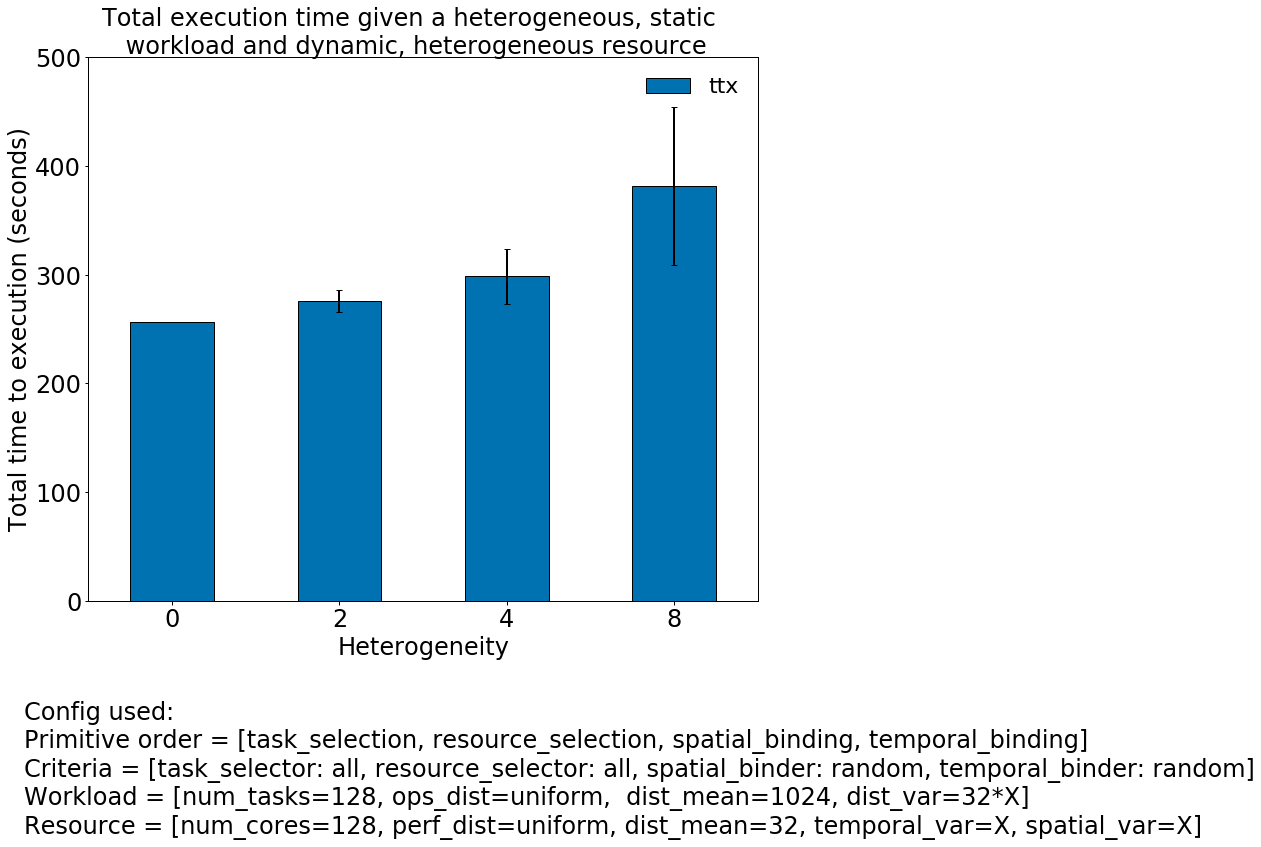

In [77]:
fig = plot_ttx(df_dict)
title = 'Total execution time given a heterogeneous, static \n workload and dynamic, heterogeneous resource'
fig.suptitle(title, y=0.95)
txt = 'Config used:'+ \
        '\nPrimitive order = [task_selection, resource_selection, spatial_binding, temporal_binding]' + \
        '\nCriteria = [task_selector: all, resource_selector: all, spatial_binder: random, temporal_binder: random]' + \
        '\nWorkload = [num_tasks=128, ops_dist=uniform,  dist_mean=1024, dist_var=32*X]' + \
        '\nResource = [num_cores=128, perf_dist=uniform, dist_mean=32, temporal_var=X, spatial_var=X]' 
x = fig.text(0.05,-0.2, txt)
fname = 'ttx_early_binding_rand.png'
fig.savefig('%s'%fname)